In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test["is_promoted"] = np.nan
print train.shape, test.shape

(54808, 14) (23490, 14)


# Simple LGBM Model

In [3]:
train_id = train[["employee_id"]]
test_id = test[["employee_id"]]
target = train.is_promoted

train = train.drop(["employee_id","is_promoted"], axis=1)
test = test.drop(["employee_id","is_promoted"], axis=1)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
data["education"] = data["education"].fillna("NoData")

# Feature Engineering Start
data["department_size"] = data["department"].map(data.groupby("department").size())

data["department_average_training_scores"] = data["department"].map(data.groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_average_training_score_in_department"] = data.apply(lambda x: ((x["department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["department_average_training_scores"]), axis=1)
data = data.drop(["department_average_training_scores"], axis=1)

data["kpi_positive_department_average_training_scores"] = data["department"].map(data.loc[data["KPIs_met >80%"] ==1].groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_kpi_positive_average_training_score_in_department"] = data.apply(lambda x: ((x["kpi_positive_department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["kpi_positive_department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["kpi_positive_department_average_training_scores"]), axis=1)
data = data.drop(["kpi_positive_department_average_training_scores"], axis=1)

# Feature Engineering End


data = pd.get_dummies(data, columns = data.select_dtypes(include='object').columns)

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [4]:
def f1_score_calculator(y_true, y_pred):
    bst = 0
    split_by = 0.0
    for i in range(100):
        fs = f1_score(y_true, (y_pred>i/100.0).astype(int))
        if fs > bst:
            bst , split_by = fs, i/100.0
        else:
            pass
    return split_by, bst 

In [5]:
import lightgbm as lgb
def model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        'num_leaves': 32, 
        'reg_alpha': 0.04, 
        'n_jobs': -1, 
        'colsample_bytree': 0.9497036, 
        'silent': -1, 
        'subsample_for_bin': 200000, 
        'subsample_freq': 1, 
        'learning_rate': 0.02, 
        'boosting_type': 'gbdt', 
        'nthread': 8, 
        'min_child_weight': 40, 
        'min_split_gain': 0.0222415, 
        'n_estimators': 10000, 
        'subsample': 0.8715623, 
        'reg_lambda': 0.073, 
        'objective': "binary",
        'verbose': -1, 
        'min_child_samples': 20, 
        'max_depth': 4, 
        'class_weight': None,
        "nthread":8,
        "bagging_seed" : 42,
        "seed":98,
        "metric":"auc"
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    split, bst = f1_score_calculator(y_test, meta_train[test_index])
    
    meta_train[test_index] = (meta_train[test_index] > split).astype(int)
    meta_test.append((model.predict(test, num_iteration=model.best_iteration or 5000) > split).astype(int))
    
    print "Fold {} best Split {} and best Score {}".format(fold_id,split, bst)
        
    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    fold_feature_importance = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()})
    feature_importance = feature_importance.append(fold_feature_importance, ignore_index=True) 

In [6]:
meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame()

kf = StratifiedKFold(n_splits= 70, shuffle=True, random_state=1343)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)
print "Overall Score: {}".format(f1_score(target, meta_train))

train_id["is_promoted"] = meta_train
test_id["is_promoted"] = (np.array(meta_test).T.mean(axis=1) > 0.5).astype(int)

/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90149	valid_1's auc: 0.918858
[200]	training's auc: 0.909887	valid_1's auc: 0.918774
[300]	training's auc: 0.912839	valid_1's auc: 0.918296
Early stopping, best iteration is:
[187]	training's auc: 0.908819	valid_1's auc: 0.919607
Fold 0 best Split 0.44 and best Score 0.618556701031


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902195	valid_1's auc: 0.889704
[200]	training's auc: 0.910089	valid_1's auc: 0.904224
[300]	training's auc: 0.912857	valid_1's auc: 0.907304
[400]	training's auc: 0.915641	valid_1's auc: 0.906534
[500]	training's auc: 0.916978	valid_1's auc: 0.906576
Early stopping, best iteration is:
[303]	training's auc: 0.913086	valid_1's auc: 0.907721
Fold 1 best Split 0.2 and best Score 0.516129032258
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902282	valid_1's auc: 0.889059
[200]	training's auc: 0.909702	valid_1's auc: 0.896501
[300]	training's auc: 0.912741	valid_1's auc: 0.900539
[400]	training's auc: 0.915397	valid_1's auc: 0.904421
[500]	training's auc: 0.916868	valid_1's auc: 0.906066
[600]	training's auc: 0.918276	valid_1's auc: 0.907825
[700]	training's auc: 0.919527	valid_1's auc: 0.908241
[800]	training's auc: 0.920592	valid_1's auc: 0.908741
[900]	training's 

[300]	training's auc: 0.912953	valid_1's auc: 0.88068
Early stopping, best iteration is:
[186]	training's auc: 0.909532	valid_1's auc: 0.88322
Fold 11 best Split 0.21 and best Score 0.558558558559
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901859	valid_1's auc: 0.884916
[200]	training's auc: 0.909618	valid_1's auc: 0.891578
[300]	training's auc: 0.912644	valid_1's auc: 0.894201
[400]	training's auc: 0.915542	valid_1's auc: 0.897864
[500]	training's auc: 0.916993	valid_1's auc: 0.899124
[600]	training's auc: 0.918393	valid_1's auc: 0.89929
[700]	training's auc: 0.919647	valid_1's auc: 0.899498
[800]	training's auc: 0.920641	valid_1's auc: 0.89954
[900]	training's auc: 0.921515	valid_1's auc: 0.900206
[1000]	training's auc: 0.922315	valid_1's auc: 0.900206
[1100]	training's auc: 0.923305	valid_1's auc: 0.900768
[1200]	training's auc: 0.924145	valid_1's auc: 0.900498
[1300]	training's auc: 0.92477	valid_1's auc: 0.900976
[1400]	training's auc: 0

[1200]	training's auc: 0.923812	valid_1's auc: 0.923914
[1300]	training's auc: 0.924555	valid_1's auc: 0.923872
[1400]	training's auc: 0.925186	valid_1's auc: 0.923705
Early stopping, best iteration is:
[1221]	training's auc: 0.92398	valid_1's auc: 0.924227
Fold 23 best Split 0.19 and best Score 0.58904109589
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902199	valid_1's auc: 0.890384
[200]	training's auc: 0.910336	valid_1's auc: 0.899327
[300]	training's auc: 0.912962	valid_1's auc: 0.900702
[400]	training's auc: 0.915513	valid_1's auc: 0.903621
[500]	training's auc: 0.917003	valid_1's auc: 0.906967
[600]	training's auc: 0.91835	valid_1's auc: 0.907488
[700]	training's auc: 0.919587	valid_1's auc: 0.908947
[800]	training's auc: 0.920654	valid_1's auc: 0.908801
[900]	training's auc: 0.921505	valid_1's auc: 0.909614
[1000]	training's auc: 0.922344	valid_1's auc: 0.910531
[1100]	training's auc: 0.923163	valid_1's auc: 0.910114
[1200]	training's au

Fold 36 best Split 0.3 and best Score 0.594059405941
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902057	valid_1's auc: 0.8861
[200]	training's auc: 0.910035	valid_1's auc: 0.890061
[300]	training's auc: 0.91306	valid_1's auc: 0.891364
[400]	training's auc: 0.915809	valid_1's auc: 0.892812
[500]	training's auc: 0.917347	valid_1's auc: 0.893605
[600]	training's auc: 0.918636	valid_1's auc: 0.893605
[700]	training's auc: 0.919775	valid_1's auc: 0.895668
[800]	training's auc: 0.920971	valid_1's auc: 0.897065
[900]	training's auc: 0.921727	valid_1's auc: 0.898941
[1000]	training's auc: 0.922641	valid_1's auc: 0.899796
[1100]	training's auc: 0.923465	valid_1's auc: 0.900463
[1200]	training's auc: 0.924223	valid_1's auc: 0.901213
[1300]	training's auc: 0.924955	valid_1's auc: 0.901901
[1400]	training's auc: 0.92567	valid_1's auc: 0.902339
[1500]	training's auc: 0.926325	valid_1's auc: 0.902464
[1600]	training's auc: 0.926907	valid_1's auc: 0.901859
[

[100]	training's auc: 0.902272	valid_1's auc: 0.892807
[200]	training's auc: 0.910133	valid_1's auc: 0.901632
[300]	training's auc: 0.912857	valid_1's auc: 0.902806
[400]	training's auc: 0.915678	valid_1's auc: 0.905546
[500]	training's auc: 0.917101	valid_1's auc: 0.907123
[600]	training's auc: 0.918415	valid_1's auc: 0.907821
[700]	training's auc: 0.919712	valid_1's auc: 0.908964
[800]	training's auc: 0.920675	valid_1's auc: 0.909281
[900]	training's auc: 0.921518	valid_1's auc: 0.909662
[1000]	training's auc: 0.922499	valid_1's auc: 0.908562
Early stopping, best iteration is:
[876]	training's auc: 0.921337	valid_1's auc: 0.909853
Fold 48 best Split 0.37 and best Score 0.551020408163
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901755	valid_1's auc: 0.906118
[200]	training's auc: 0.910244	valid_1's auc: 0.914826
[300]	training's auc: 0.912948	valid_1's auc: 0.914212
Early stopping, best iteration is:
[158]	training's auc: 0.907553	valid_1's a

[1100]	training's auc: 0.923521	valid_1's auc: 0.902743
Early stopping, best iteration is:
[954]	training's auc: 0.922319	valid_1's auc: 0.903674
Fold 61 best Split 0.27 and best Score 0.538461538462
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902188	valid_1's auc: 0.882629
[200]	training's auc: 0.910024	valid_1's auc: 0.893876
[300]	training's auc: 0.912871	valid_1's auc: 0.892574
[400]	training's auc: 0.915708	valid_1's auc: 0.893643
Early stopping, best iteration is:
[218]	training's auc: 0.910781	valid_1's auc: 0.895791
Fold 62 best Split 0.24 and best Score 0.474226804124
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90182	valid_1's auc: 0.925279
[200]	training's auc: 0.909951	valid_1's auc: 0.932781
[300]	training's auc: 0.912643	valid_1's auc: 0.933966
[400]	training's auc: 0.915239	valid_1's auc: 0.933511
[500]	training's auc: 0.916926	valid_1's auc: 0.933257
Early stopping, best iteration is:
[

In [7]:
test_id.to_csv("csv/prediction3.csv", index = False)

In [8]:
test_id["is_promoted"].mean()

0.04993614303959132

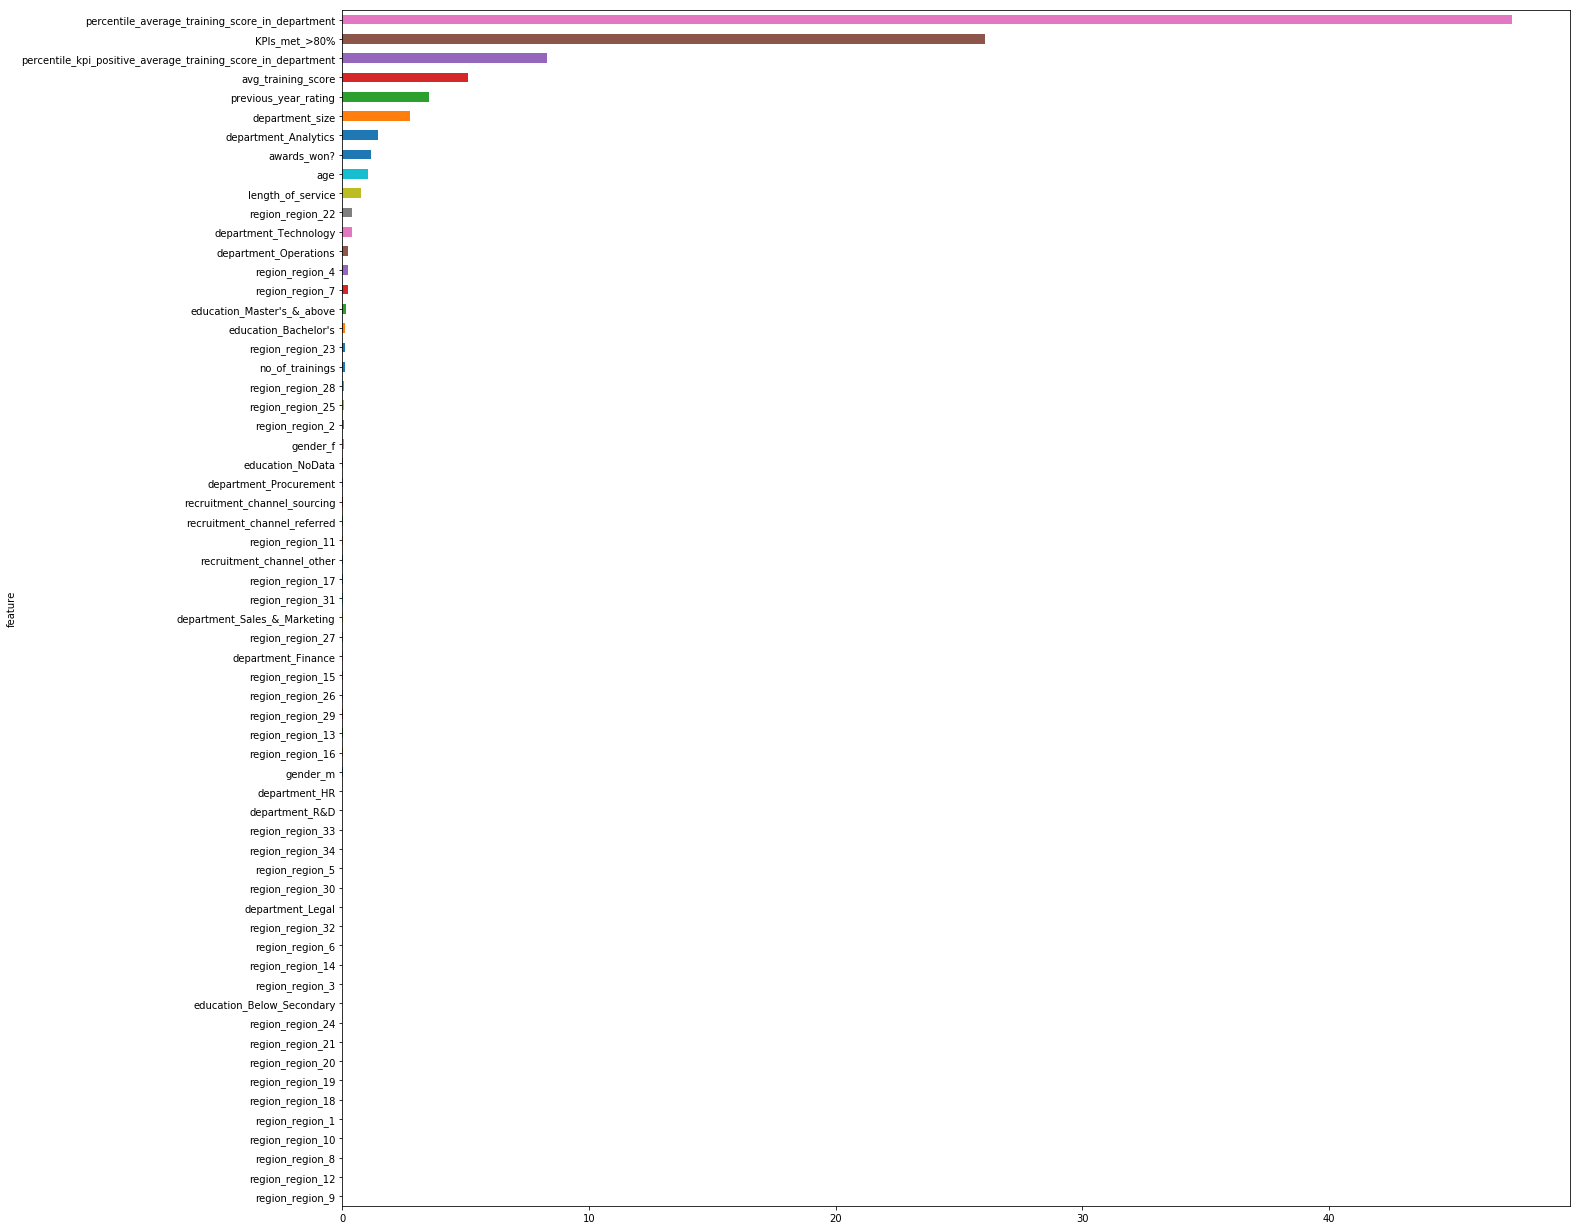

In [9]:
feature_importance.groupby("feature")["gain"].mean().sort_values().plot(kind = "barh", figsize = (22,22))